Summary:

Author: E.R.

Last modified: Tuesday 25/10/2022 19:07

version: 1

# User-Chosen Parameters

In [13]:
# IF NOT USING THE FULL 15s AUDIOWAVES, CHOOSE WHERE EACH SIGNAL SHOULD START AND ALSO THE DURATION OF THE CLIP
# NUMBERS REPRESENT SECONDS (from 0 to 15)
# SIGNAL_START + SIGNAL DURATION CAN NOT BE > 15


# for the parasite call
signal_start_P1 = 6
signal_duration_P1 = 3

# for the single host call
signal_start_SH1 = 10
signal_duration_SH1 = 3

In [47]:
# Toggle on/off for displaying plots and listening to audio within the notebook

make_plots = 1 # should plots be shown for all parts of the signal processing?  1 = YES, 0 = NO
audio_player_widget = 1 # insert an audio player widget to listen to the signals within this notebook 1 = YES, 0 = NO

In [51]:
# Frequency range for bank-filtering of signals
# Need to choose: minimum frequency, maximum frequncy, and number of bank-filters
# The maximum frequency can not be higher than ha;f the sampling rate (in our case sr = 22050Hz, so the maximum frequncy should be <11025)

min_bank_f = 2
max_bank_f = 10312 #(empirically chosen. Above this there is practically no power in the audios)
n_bank = 16

freqs = np.linspace(min_bank_f,max_bank_f,n_bank+1)

print('the frequency intervals are:',freqs)

the frequency intervals are: [2.000000e+00 6.463750e+02 1.290750e+03 1.935125e+03 2.579500e+03
 3.223875e+03 3.868250e+03 4.512625e+03 5.157000e+03 5.801375e+03
 6.445750e+03 7.090125e+03 7.734500e+03 8.378875e+03 9.023250e+03
 9.667625e+03 1.031200e+04]


In [69]:
# CHOOSE LIMITS OF THE BANDSTOP FILTER (in Hz). THIS IS THE AMPLITUDE MODULATION BAND TO BE REMOVED FROM THE AMPLITUDE ENVELOPES OF THE SIGNALS
low_bs_f = 11.5
high_bs_f = 28


# Set up environment 

In [1]:
!git clone https://github.com/MuSAELab/amplitude-modulation-analysis-module.git
!pip install /content/amplitude-modulation-analysis-module

Cloning into 'amplitude-modulation-analysis-module'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 143 (delta 0), reused 1 (delta 0), pack-reused 140
Receiving objects: 100% (143/143), 785.74 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./amplitude-modulation-analysis-module
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for am-analysis: filename=am_analysis-0.1-py3-none-any.whl size=20028 sha256=e478376

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert, butter, lfilter, freqz
from scipy import signal as sig
import pandas as pd
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

import os

from am_analysis import am_analysis as ama

# Get Data

In [3]:
!gdown 159nFA9ivEE5dQkRDB7hOop90_unzlEve

Downloading...
From: https://drive.google.com/uc?id=159nFA9ivEE5dQkRDB7hOop90_unzlEve
To: /content/LT075_161IM_15s.wav
100% 1.44M/1.44M [00:00<00:00, 108MB/s]


In [4]:
!gdown 1RC9zzB8dbWwWw8FN1qdlr8LlpQZllJs2

Downloading...
From: https://drive.google.com/uc?id=1RC9zzB8dbWwWw8FN1qdlr8LlpQZllJs2
To: /content/LT117_161LT.wav
100% 1.44M/1.44M [00:00<00:00, 41.8MB/s]


# Build some filters 

## Bandpass (Butterworth) filter

In [5]:

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    y = sig.filtfilt(b, a, data, method='gust')

    return y



## another bandpass filter using *FIR*

In [6]:

def bandpass(input, fs, fpl, fph, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a bandpass filter.
        fs : sampling frequency (Hz)
        fpl : low pass frequency (Hz)
        fph : high pass frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, [fpl / (fs * 0.5), fph / (fs * 0.5)], window=('kaiser', beta),pass_zero='bandpass')

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input, method = 'pad', padtype = 'constant')

        return input_filt

## lowpass filter

In [7]:
def lowpass(input, fs, fc, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a low-pass filter.
        fs : sampling frequency (Hz)
        fc : cut-off frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, fc / (fs * 0.5), window=('kaiser', beta))

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input, method = 'pad', padtype = 'constant')

        return input_filt

## bandstop (notch) filter

In [8]:
def bandstop(input,fs, fstop, quality_factor=1.2):
    """
    Designs a IIR bandstop filter.
    fs : sampling frequency (Hz)
    fstop : frequency to remove (Hz)
    quality_factor : dimensionless parameter that characterises quality
    """
    b_notch, a_notch = sig.iirnotch(fstop, quality_factor, fs)
    input_notched = sig.filtfilt(b_notch, a_notch, input)
    w,h = sig.freqz(b_notch, a_notch, worN=16384)
    return input_notched, w, h


## Bandstop (Butterworth) filter


In [9]:


#def butter_bandstop(lowcut, highcut, fs, order=3):
#    nyq = 0.5 * fs
#    low = lowcut / nyq
#    high = highcut / nyq
#    b, a = butter(order, [low, high], btype='bandstop')
#    return b, a


def butter_bandstop_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    #b, a = butter_bandstop(lowcut, highcut, fs, order=order)

    z, p, k = sig.tf2zpk(b, a)
    eps = 1e-9
    r = np.max(np.abs(p))
    approx_impulse_len = int(np.ceil(np.log(eps) / np.log(r)))


    y = sig.filtfilt(b, a, data, method='gust',irlen=approx_impulse_len)

    w,h = sig.freqz(b, a, worN=16384)
    f=(fs/2)*w/(np.pi)  
    return y, f , h

# Read in and examine audiowaves

**choose a file for parasite 1 (audiofile_P1)**

In [10]:
audiofile_P1 = '/content/LT075_161IM_15s.wav'

**choose a file for brood host 1 (audiofile_BH1)**

In [11]:
audiofile_SH1 = '/content/LT117_161LT.wav'

**Plot the full audiowaves (named `signal_full_P1` and `signal_full_SH1`)**

total audio duration of file /content/LT075_161IM_15s.wav is : 15.02s


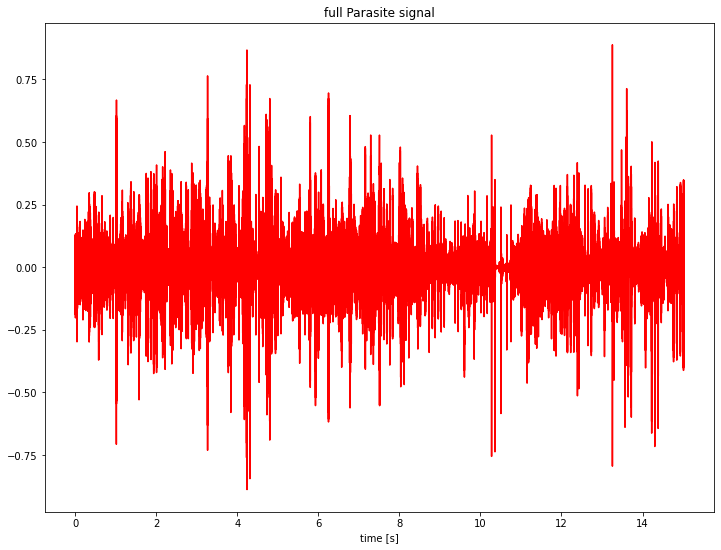

In [35]:
signal_full_P1, sr = librosa.load(audiofile_P1)
print(f'total audio duration of file {audiofile_P1} is : {len(signal_full_P1)/sr:.2f}s')


if make_plots:

  t = np.linspace(0,len(signal_full_P1)/sr, len(signal_full_P1))
  plt.figure(figsize=(12,9))  
  plt.plot(t, signal_full_P1,c='r')
  plt.xlabel('time [s]')
  plt.title('full Parasite signal')
  plt.plot()

In [48]:
if audio_player_widget:

  print('PARASITE FULL DURATION AUDIO')
  Audio(data=signal_full_P1,rate=sr)


PARASITE FULL DURATION AUDIO


total audio duration of file LT117_161LT.wav is : 15.03s


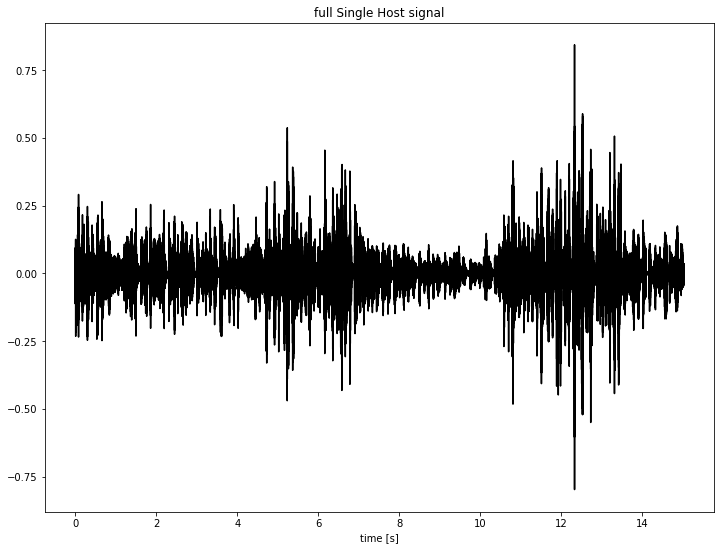

In [38]:
signal_full_SH1, sr = librosa.load(audiofile_SH1)
print(f'total audio duration of file {audiofile_SH1} is : {len(signal_full_SH1)/sr:.2f}s')


if make_plots:
  t = np.linspace(0,len(signal_full_SH1)/sr, len(signal_full_SH1))
  plt.figure(figsize=(12,9))
  plt.plot(t, signal_full_SH1,c='k')
  plt.xlabel('time [s]')
  plt.title('full Single Host signal')
  plt.plot()



In [49]:
if audio_player_widget:
  print('SINGLE HOST FULL DURATION AUDIO')
  Audio(data=signal_full_SH1,rate=sr)   


SINGLE HOST FULL DURATION AUDIO


**Choose only a small clip (named `signalP1` and `signalSH1`) to work on**

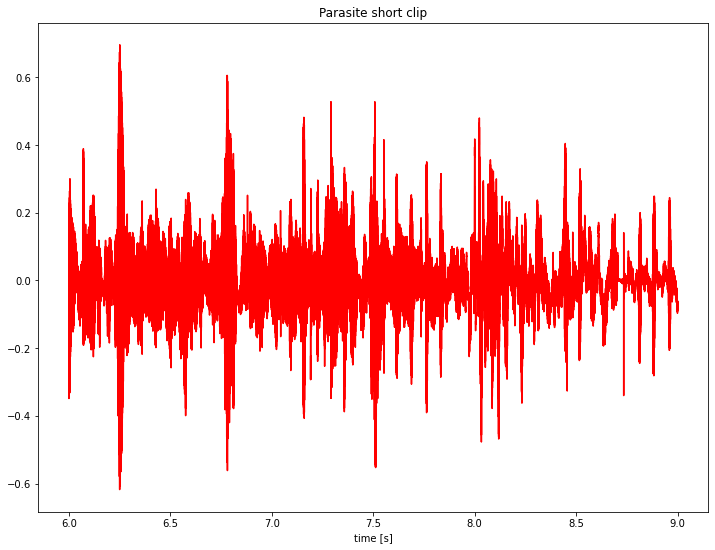

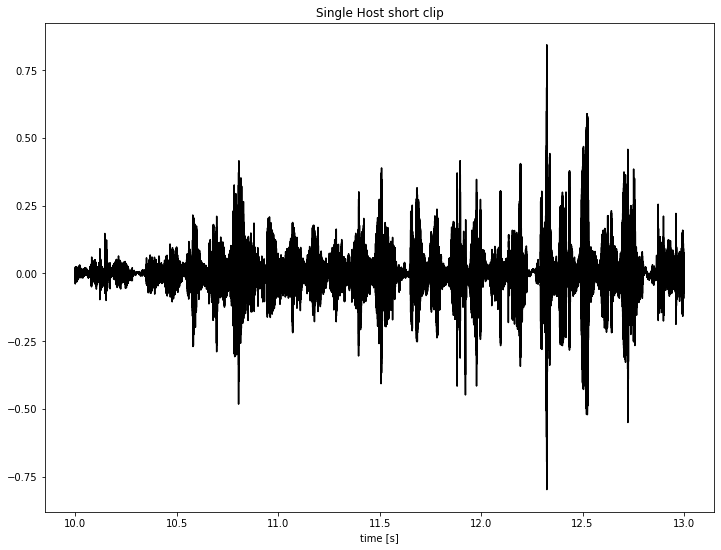

In [44]:
signalP1 = signal_full_P1[signal_start_P1*sr:(signal_start_P1 + signal_duration_P1)*sr]

signalSH1 = signal_full_SH1[signal_start_SH1*sr:(signal_start_SH1 + signal_duration_SH1)*sr]

if make_plots:    

  tP1 = np.linspace(signal_start_P1,signal_start_P1+signal_duration_P1, len(signalP1))
  plt.figure(figsize=(12,9))
  plt.plot(tP1, signalP1,c='r')
  plt.xlabel('time [s]')
  plt.title('Parasite short clip')
  plt.plot()



  tSH1 = np.linspace(signal_start_SH1,signal_start_SH1+signal_duration_SH1, len(signalSH1))
  plt.figure(figsize=(12,9))
  plt.plot(tSH1, signalSH1,c='k')
  plt.xlabel('time [s]')
  plt.title('Single Host short clip')
  plt.plot()


In [45]:
if audio_player_widget:
  print('SELECTED PART OF PASARISE AUDIO CLIP')

  Audio(data=signalP1,rate=sr)  

SELECTED PART OF PASARISE AUDIO CLIP


In [50]:
if audio_player_widget:

  print('SELECTED PART OF SINGLE HOST AUDIO CLIP')

  Audio(data=signalSH1,rate=sr)

SELECTED PART OF SINGLE HOST AUDIO CLIP


# Useful Functions

In [54]:
def apply_bank_filters(signal, sr, freqs, make_plots=1, bandwidth = 10, ripple_db = 50):


# apply bank-filters to the original parasite signal to create narrowband signals.

# timepoints for the plots
  t = np.linspace(0,len(signal)/sr, len(signal), endpoint=False)


  bp_signal = []
  for i in range(len(freqs)-1):
    lowcut = freqs[i]
    highcut = freqs[i+1]

    bp_signal.append(bandpass(signal, sr, lowcut, highcut, bandwidth=10,ripple_db=50))
    if make_plots:
      plt.figure(figsize=(10,7))
      plt.clf()
      plt.plot(t, signal, label='Original full signal')
      plt.plot(t, bp_signal[i], label='Original narrowband signal' )
      plt.xlabel('time (seconds)')
      plt.grid(True)
      plt.axis('tight')
      #plt.ylim([-1,1])
      plt.legend(loc='upper left')
      plt.title(str(round(lowcut,1))+' - '+str(round(highcut,1))+' Hz')
      plt.show()
  return bp_signal  

In [64]:
def get_AE(signal, sr, freqs, make_plots=1):

# For each of the original narrowband signals get the A.E. using Hilbert transform

  amp_env = []
  inst_phase_o = []
  f_i=0

  for s in signal:
    t = np.linspace(0,len(s)/sr, len(s), endpoint=False)
    lowcut = freqs[f_i]
    highcut = freqs[f_i+1]
    z = (hilbert(s)) #form the analytical signal
    amp_env.append(np.abs(z)) #envelope extraction
    inst_phase_o.append(np.unwrap(np.angle(z)))#inst phase
    inst_freq = np.diff(inst_phase_o)/(2*np.pi)*sr #inst frequency

    plt.figure(figsize=(10,7))
    plt.plot(t,s)
    plt.plot(t,amp_env[-1])
    #plt.ylim([-0.5,0.5])
    plt.xlabel('time [s]')
    plt.ylabel('Amplitude')
    plt.title(str(round(lowcut,1))+' - '+str(round(highcut,1))+' Hz')
    plt.show()
    f_i+=1
  return amp_env    

In [81]:

def mod_amp_filter(amp_env, sr, low_cutoff, high_cutoff, order = 2, make_plots = 1, plot_response = 1):

  amp_env_filtered=[]
  for ae in amp_env:
    y , f ,h = butter_bandstop_filter(ae, low_cutoff, high_cutoff, sr, order=2)
    amp_env_filtered.append(y)
    if make_plots:
      t = np.linspace(0,len(ae)/sr, len(ae), endpoint=False)
      plt.figure(figsize=(12,9))
      plt.plot(t,ae, label='original AE')
      plt.plot(t,amp_env_filtered[-1], label='bandstop-filtered AE')
      plt.legend()
      plt.xlabel('time [s]')
      plt.show()
  if make_plots and plot_response:
    plt.figure(figsize=(12,9))
    plt.plot(f,abs(h))
    #plt.plot(f,20*np.log10(abs(h)))
    plt.plot([low_cutoff,low_f],[0,1])
    plt.plot([high_cutoff,high_f],[0,1])
    #plt.xlim([1050,1150])
    plt.xlabel('Frequency [Hz]')
    #plt.ylabel('Amplitude [dB]')
    plt.xscale('log')
    plt.title('Bandstop filter frequency response')
    plt.show()
  return amp_env_filtered

In [114]:
def sig_removed(amp_env, amp_env_filtered, make_plots = 1):

# this is the difference (in the time-amplitude domain) between the original narrowband AEs and the filtered narrowband AEs 
# (i.e. AE with specific modulation frequencies removed).

  sig_removed = np.subtract(amp_env, amp_env_filtered)

  if make_plots:
    for i in range(len(sig_removed)):
      plt.figure(figsize=(10,7))
      plt.plot(amp_env[i],label='orig. AE')
      plt.plot(sig_removed[i],label='orig. AE - mod. AE ')
      plt.legend()
      plt.show()
  return sig_removed

In [120]:
def implant(amp_env_recipient, extracted_donor_signal):

#implant an extracted signal from the AEs of one signal (donor) into the AEs of another signal (recipient)

  if len(amp_env_recipient) != len(extracted_donor_signal):
    print('the recipient and donor signals should be of the same length')
    return

  modified_amp_env = []

  for i in range(len(amp_env_recipient)):
    modified_amp_env.append(amp_env_recipient[i] + extracted_donor_signal[i])

  return modified_amp_env

# **Modulation filtering** *(remove AE frequencies from Parasite and Single Host)*

## Filter-bank original signals

### Parasite

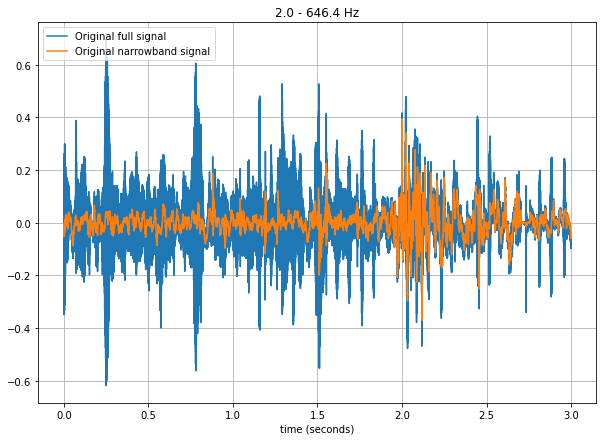

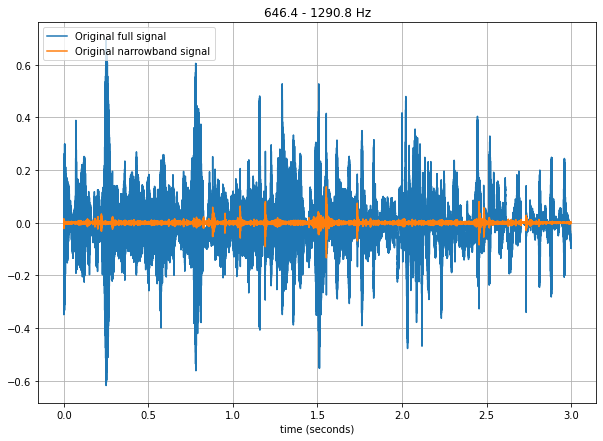

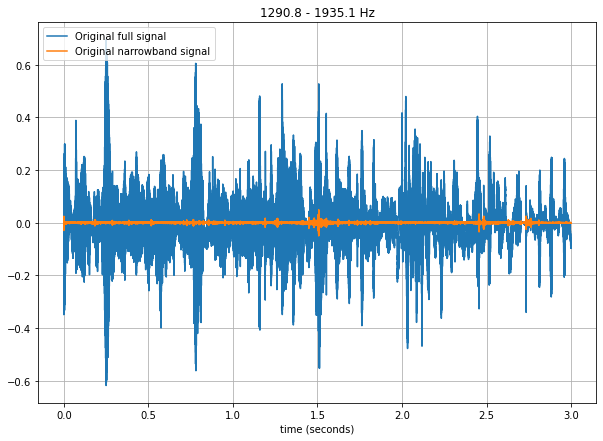

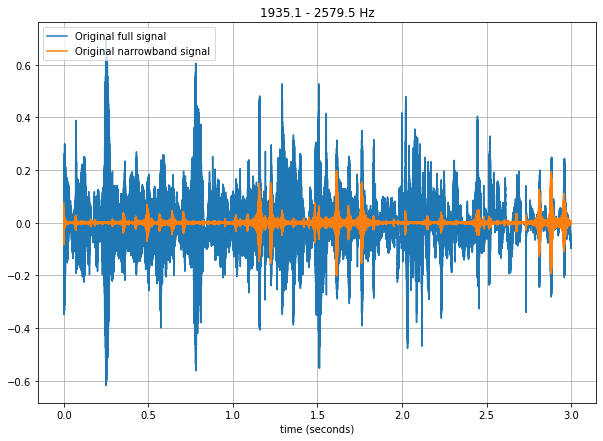

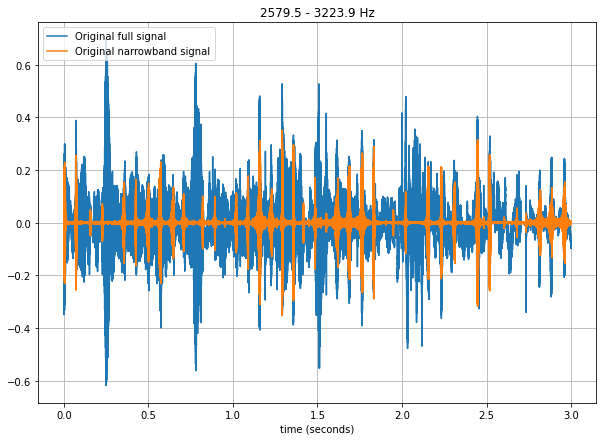

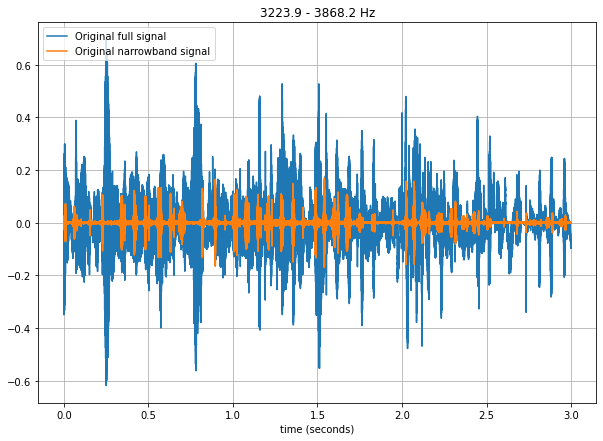

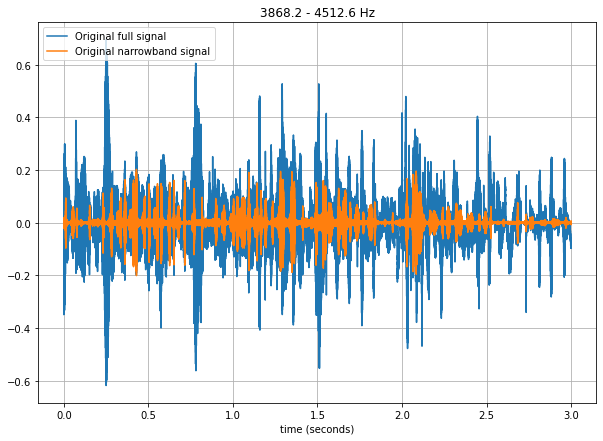

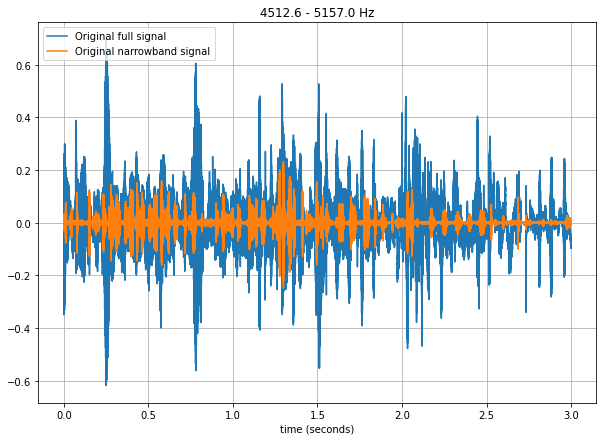

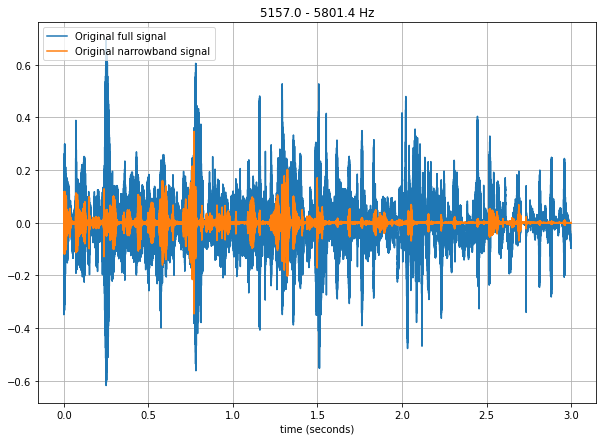

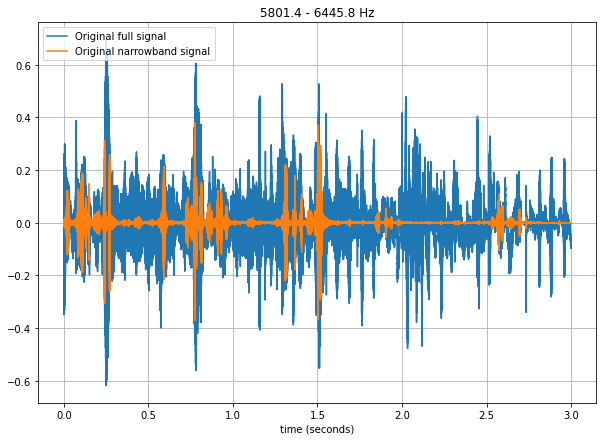

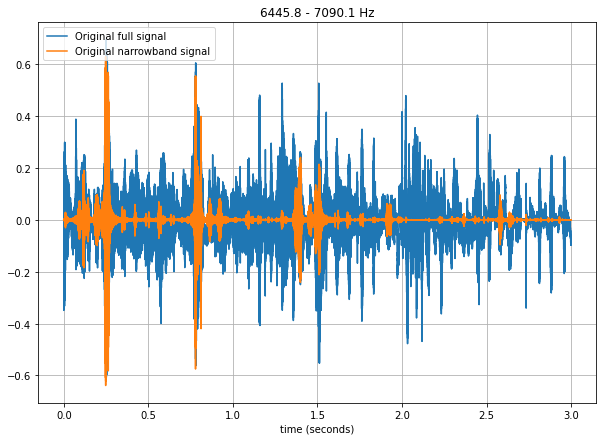

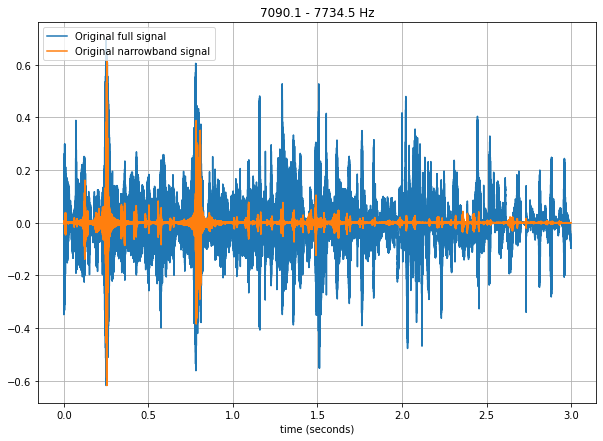

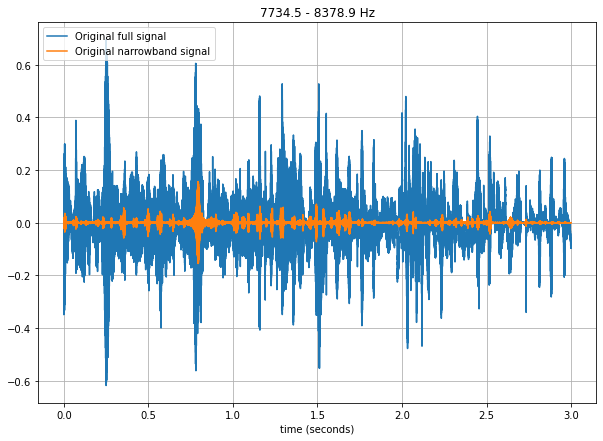

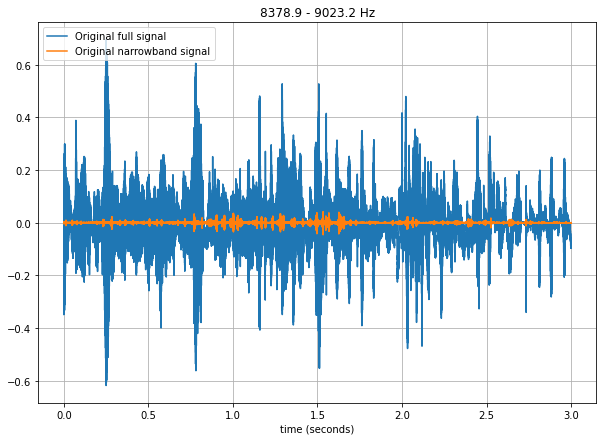

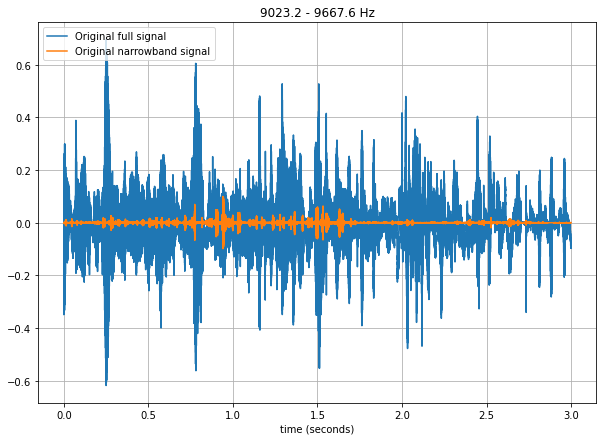

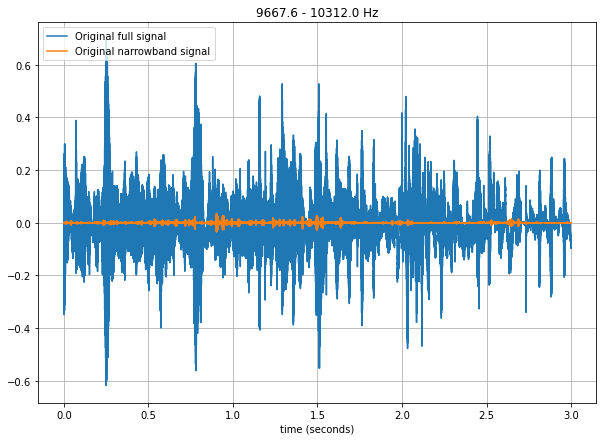

In [55]:
bp_signalP1 = apply_bank_filters(signalP1, sr, freqs, make_plots=1, bandwidth = 10, ripple_db = 50)

### Single Host

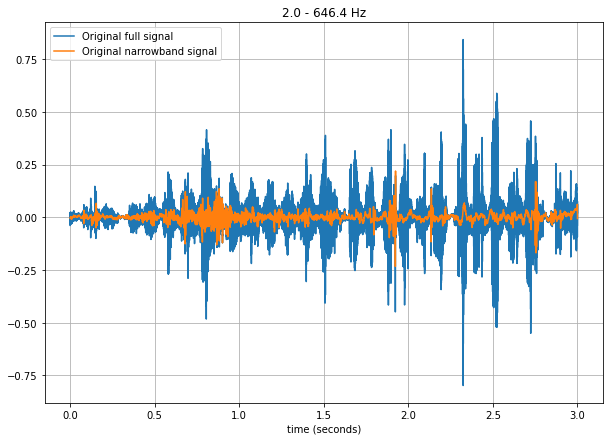

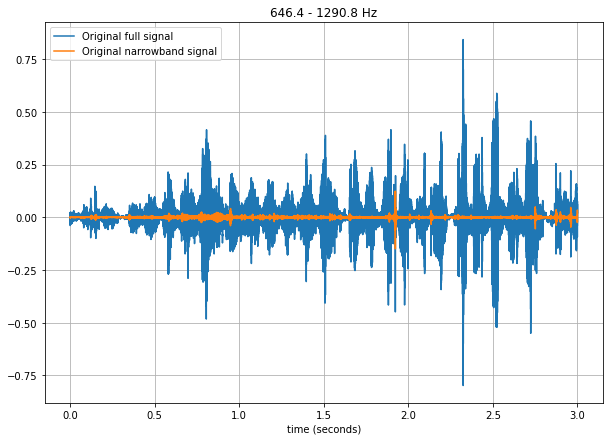

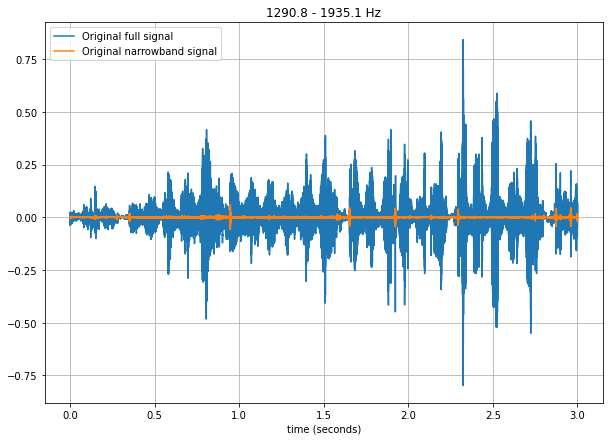

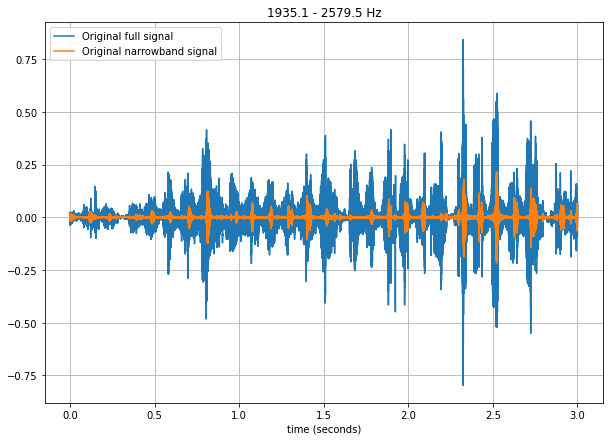

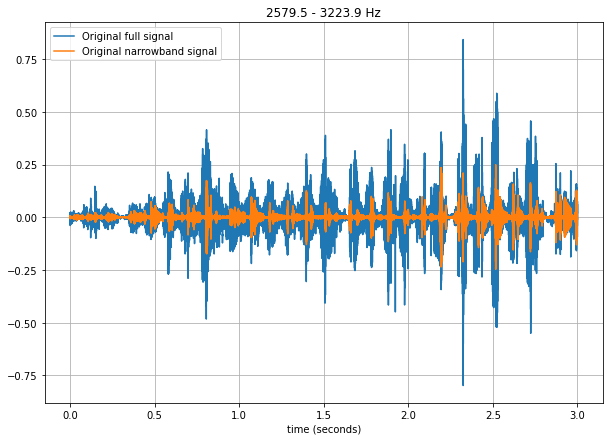

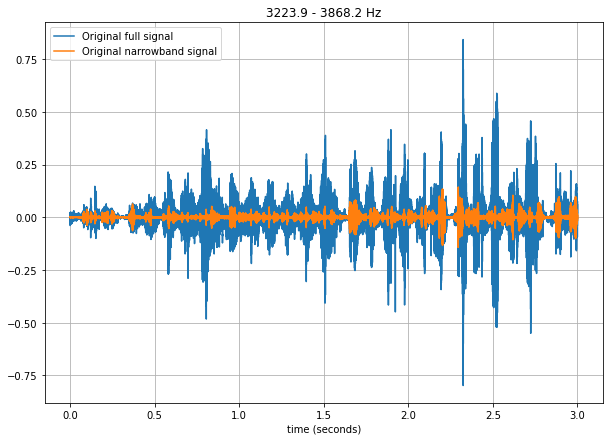

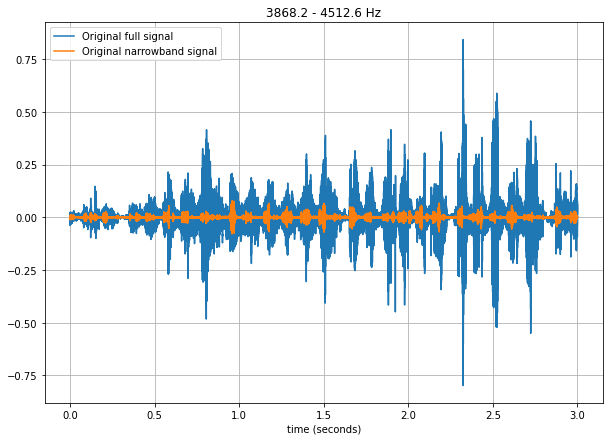

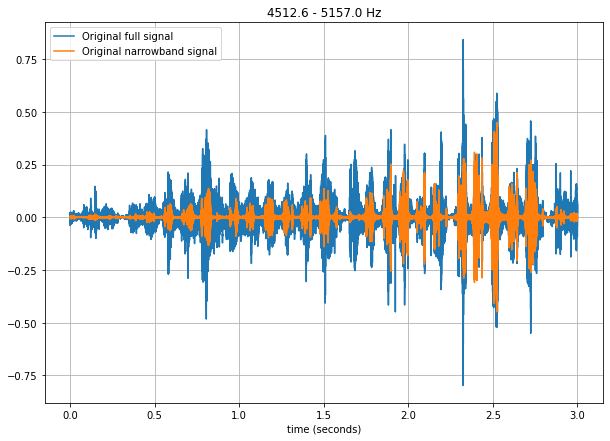

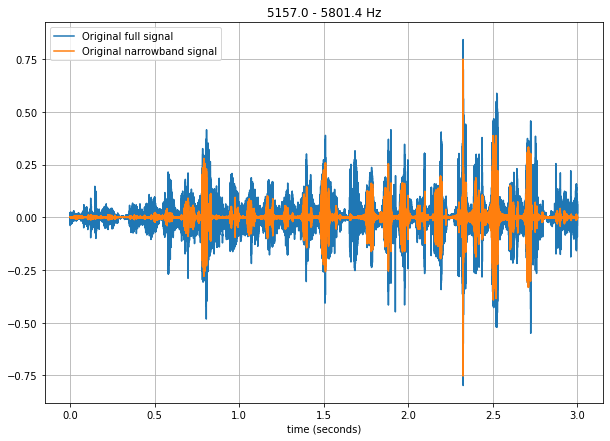

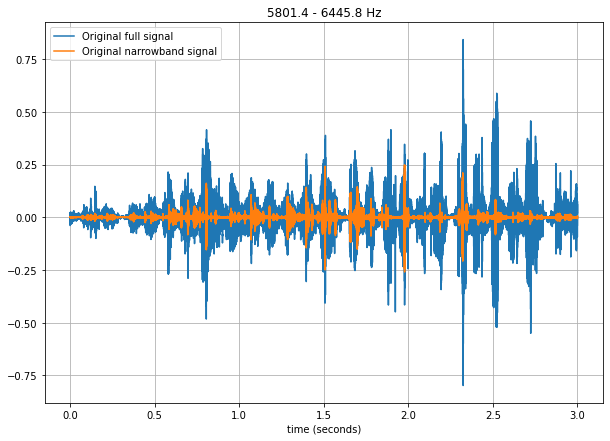

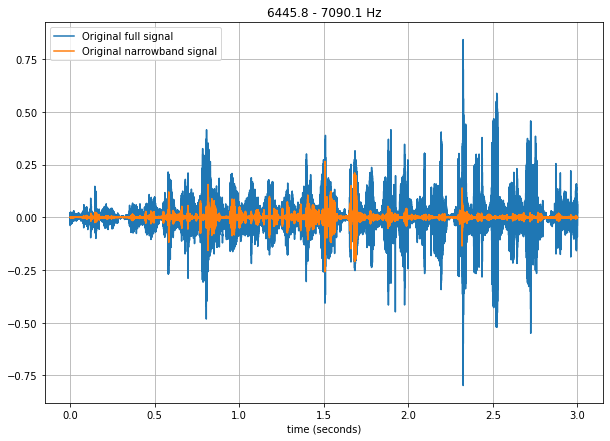

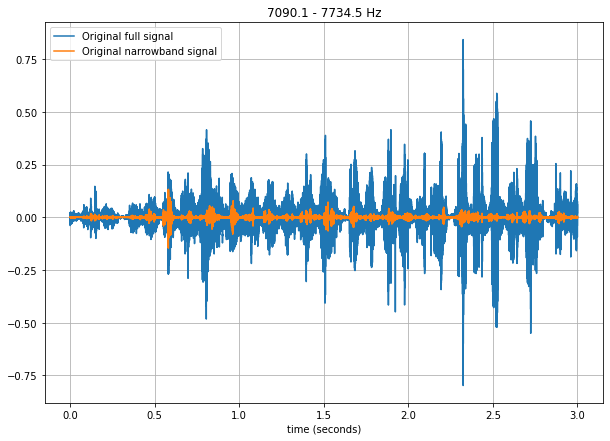

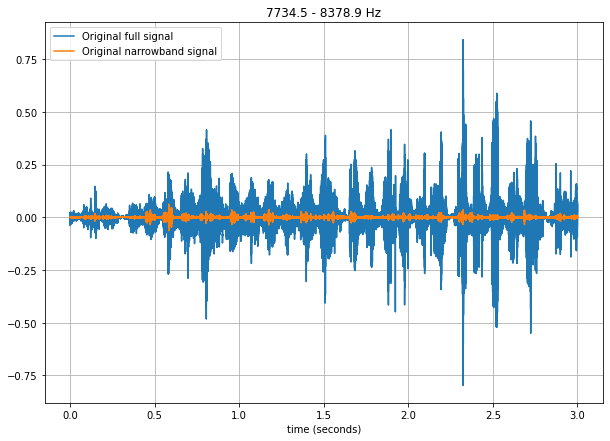

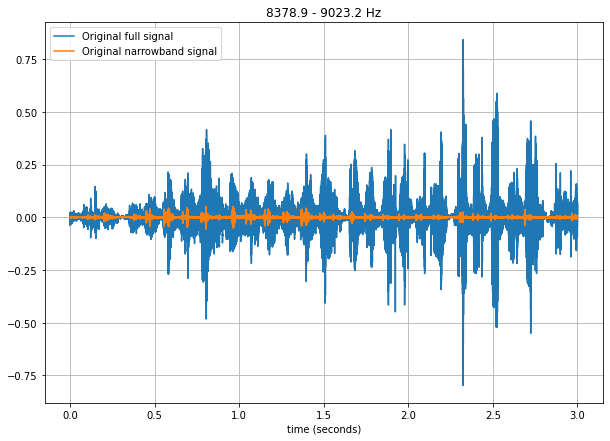

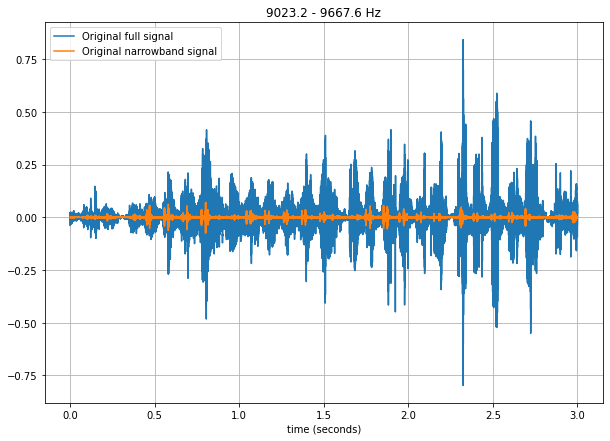

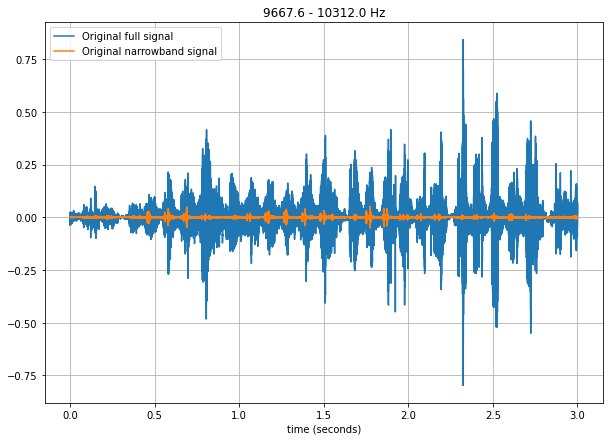

In [56]:
bp_signalSH1 = apply_bank_filters(signalSH1, sr, freqs, make_plots=1, bandwidth = 10, ripple_db = 50)

##  Get Amplitude Envelopes (AE)

###For Parasite

In [ ]:
amp_env_P1 = get_AE(bp_signalP1,sr,freqs,make_plots=1)

###For Single Host

In [ ]:
amp_env_SH1 = get_AE(bp_signalP1,sr,freqs,make_plots=1)

##  Filter AEs using Butterworth bandstop filter

###For Parasite

In [85]:
amp_env_filtered_P1 = mod_amp_filter(amp_env_P1, sr, low_bs_f, high_bs_f, make_plots = 0, plot_response = 1)

###For Single Host

In [86]:
amp_env_filtered_SH1 = mod_amp_filter(amp_env_SH1, sr, low_bs_f, high_bs_f, make_plots=0, plot_response = 1)

## Find diff between original AEs and filtered AEs

###For Parasite

In [115]:
sig_removed_P1 = sig_removed(amp_env_P1, amp_env_filtered_P1,make_plots = 0)

###For Single Host

In [116]:
sig_removed_SH1 = sig_removed(amp_env_SH1, amp_env_filtered_SH1, make_plots = 0)

# Implant with replacement (IR)

### For Parasite

#### with Single Host as the donor

In [ ]:
ir_amp_env_P1 = implant(amp_env_filtered_P1, sig_removed_SH1)

#### with Parasite as the donor (i.e. retrieve original Parasite signal)

In [ ]:
retrieve_amp_env_P1 = implant(amp_env_filtered_P1, sig_removed_P1)

###For Single Host

#### with Parasite as the donor

In [121]:
ir_amp_env_SH1 = implant(amp_env_filtered_SH1, sig_removed_P1)

#### with Single Host as the donor (i.e. retrieve original Single Host signal)

In [122]:
retrieve_amp_env_SH1 = implant(amp_env_filtered_SH1, sig_removed_SH1)

# Implant with addition (IA)

### For Parasite

In [ ]:
ia_amp_env_P1 = implant(amp_env_P1, sig_removed_SH1)

###For Single Host

In [123]:
ia_amp_env_SH1 = implant(amp_env_SH1, sig_removed_P1)